# 1. Import libraries

In [1]:
#pip install --upgrade --no-deps statsmodels

In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import json
from six.moves.urllib.request import urlopen
from google.colab import files
import seaborn
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from statsmodels.tsa.arima.model import ARIMA
import bz2 # bz2 for compression
import pickle # pickle for writing/reading model to/from a file

# 2. Data processing

## 2.1. Get the list of Bike Stations

In [3]:
# UPDATE:
# From 26/8/2021, the API https://dublinbikes.staging.derilinx.com/api/v1
# has been shut down. You can not get data from the API.
# So the data will be loaded from the CSV file that I already collected from
# this API in June/2021

# ----------------------------------------------------------------------
# Get the list of Bike Stations
#url = 'https://dublinbikes.staging.derilinx.com/api/v1/resources/stations'
#urlResponse = urlopen(url)
#if hasattr(urlResponse.headers, 'get_content_charset'):
#    encoding = urlResponse.headers.get_content_charset('utf-8')
#else:
#    encoding = urlResponse.headers.getparam('charset') or 'utf-8'
#data = json.loads(urlResponse.read().decode(encoding))
#stations_df = pd.DataFrame.from_dict(data, orient="columns")
# ----------------------------------------------------------------------

stations_df = pd.read_csv("drive/MyDrive/dublinbikes/datasets/station_list.csv")
stations_df

,address,station_id,latitude,longitude,name
0,Clarendon Row,1,53.340927,-6.262501,CLARENDON ROW
1,Blessington Street,2,53.356770,-6.268140,BLESSINGTON STREET
2,Bolton Street,3,53.351181,-6.269859,BOLTON STREET
3,Greek Street,4,53.346874,-6.272976,GREEK STREET
4,Charlemont Street,5,53.330662,-6.260177,CHARLEMONT PLACE
...,...,...,...,...,...
111,Merrion Square South,113,53.338615,-6.248606,MERRION SQUARE SOUTH
112,Wilton Terrace (Park),114,53.333652,-6.248345,WILTON TERRACE (PARK)
113,Killarney Street,115,53.354843,-6.247579,KILLARNEY STREET
114,Broadstone,116,53.354698,-6.272314,BROADSTONE


## 2.2. Weather data in Dublin City

In [4]:
# I've already connected my Google Drive
# Read dataset from CSV files that are stored in my Google Drive
weather1 = pd.read_csv("drive/MyDrive/dublinbikes/datasets/Dublin_weather_Jan2020_Jun2021_part1.csv")
weather2 = pd.read_csv("drive/MyDrive/dublinbikes/datasets/Dublin_weather_Jan2020_Jun2021_part2.csv")
weather3 = pd.read_csv("drive/MyDrive/dublinbikes/datasets/Dublin_weather_Jan2020_Jun2021_part3.csv")
weather4 = pd.read_csv("drive/MyDrive/dublinbikes/datasets/Dublin_weather_Jan2020_Jun2021_part4.csv")
weather5 = pd.read_csv("drive/MyDrive/dublinbikes/datasets/Dublin_weather_Jan2020_Jun2021_part5.csv")
weather6 = pd.read_csv("drive/MyDrive/dublinbikes/datasets/Dublin_weather_Jan2020_Jun2021_part6.csv")
weather7 = pd.read_csv("drive/MyDrive/dublinbikes/datasets/Dublin_weather_Jan2020_Jun2021_part7.csv")
weather8 = pd.read_csv("drive/MyDrive/dublinbikes/datasets/Dublin_weather_Jan2020_Jun2021_part8.csv")

# Combine the data of these CSV files into a dataframe
weather = pd.concat([weather1, weather2], ignore_index=True)
weather = pd.concat([weather, weather3], ignore_index=True)
weather = pd.concat([weather, weather4], ignore_index=True)
weather = pd.concat([weather, weather5], ignore_index=True)
weather = pd.concat([weather, weather6], ignore_index=True)
weather = pd.concat([weather, weather7], ignore_index=True)
weather = pd.concat([weather, weather8], ignore_index=True)

# Drop duplicated rows ()
weather.drop_duplicates(inplace=True)

# To merge the Weather data with the historic Bike-availability data,
# we need to create a field "time_interval" with format: YYYYMMDDHHmm
# YYYY: Year; MM: Month; DD: Day; HH: Hour; mm: Minute 
weather['time_interval'] = weather['Date time'].apply(lambda x: \
                            int(x[6:10] + x[0:2] + x[3:5] + x[11:13] + x[14:16]))

# Remove irrelevant columns
weather.drop(['Date time', 'Name', 'Maximum Temperature', \
              'Minimum Temperature', 'Wind Chill', 'Heat Index',	\
              'Precipitation',	'Snow',	'Snow Depth', 'Visibility',	\
              'Cloud Cover'], axis=1, inplace = True)

# Standardize the column names
weather.rename(columns={'Temperature':'temperature',	'Wind Speed':'wind_speed',	\
                        'Wind Direction':'wind_direction', 'Wind Gust':'wind_gust', \
                        'Relative Humidity':'humidity', 'Conditions':'conditions'}, inplace=True)

weather

,temperature,wind_speed,wind_direction,wind_gust,humidity,conditions,time_interval
0,6.6,3.5,67.0,5.5,84.47,Overcast,202001010000
1,6.3,2.8,44.0,4.6,84.14,Clear,202001010005
2,6.3,2.3,44.0,2.8,84.51,Clear,202001010010
3,6.3,1.9,44.0,2.8,84.73,Clear,202001010015
4,6.3,1.9,44.0,2.4,84.73,Clear,202001010020
...,...,...,...,...,...,...,...
157527,14.6,2.3,19.0,4.2,88.36,Clear,202106302340
157528,14.6,3.1,25.0,4.1,88.22,Clear,202106302345
157529,14.4,3.5,21.0,5.3,88.42,Clear,202106302350
157530,14.3,3.0,18.0,5.7,88.11,Clear,202106302355


## 2.3. Covid-19 datasets (daily confirmed new cases)

2.3.1. In the whole Ireland

In [5]:
# Read data from the CSV file
covid_ireland = pd.read_csv("drive/MyDrive/dublinbikes/datasets/CovidStatisticsProfileHPSCIrelandOpenData.csv") 

# Keep relevant columns only
covid_ireland = covid_ireland[['Date',	'ConfirmedCovidCases']]

# Standardize the column names
covid_ireland.rename(columns={'Date':'date', \
                              'ConfirmedCovidCases':'ie_confirmed_cases'}, inplace=True)

# To merge the Covid-19 data with the historic Bike-availability data,
# we need to replace the format of date with: YYYYMMDD
# YYYY: Year; MM: Month; DD: Day
covid_ireland['date'] = covid_ireland['date'].apply(lambda x: x[0:4] + x[5:7] + x[8:10])

covid_ireland

,date,ie_confirmed_cases
0,20200229,1
1,20200303,1
2,20200304,4
3,20200305,7
4,20200306,5
...,...,...
510,20210725,1126
511,20210726,1345
512,20210727,1120
513,20210728,1408


2.3.2. In Dublin city only

In [6]:
# Read data from the CSV file
covid_counties = pd.read_csv("drive/MyDrive/dublinbikes/datasets/COVID-19_County_Statistics_HPSC_Ireland_(Point_Geometry)_.csv") 

# Filter data for Dublin City & Get 2 relevant columns 
covid_dublin = covid_counties[covid_counties['CountyName'] == 'Dublin'][['ConfirmedCovidCases', 'TimeStampDate']]
# NOTE: the value of ConfirmedCovidCases is the accumulated confirmed new cases.
# It's not the daily confirmed new cases.

# Standardize the column names
covid_dublin.rename(columns={'TimeStampDate':'date', \
                             'ConfirmedCovidCases':'dublin_accumulated_confirmed_cases'}, \
                    inplace=True)

# To merge the Covid-19 data with the historic Bike-availability data,
# we need to replace the format of date with: YYYYMMDD
# YYYY: Year; MM: Month; DD: Day
covid_dublin['date'] = covid_dublin['date'].apply(lambda x: x[0:4] + x[5:7] + x[8:10])

# The original dataset has some duplicated rows that need to be removed
covid_dublin.drop_duplicates(inplace=True)

# After removing some rows, we need to reset the index of the dataframe
covid_dublin.reset_index(drop=True, inplace=True)

# Replace NA value with 0 (i.e. before Feb 2020, there is no Covid-19 cases in Dublin)
covid_dublin['dublin_accumulated_confirmed_cases'].fillna(value=0, inplace=True)

# Calculate the daily confirmed new cases
s = covid_dublin['dublin_accumulated_confirmed_cases'].copy()
a = s.pop(0)
s2 = pd.Series([s[len(s)]])
s = s.append(s2)
s = s.reset_index(drop=True)
covid_dublin['dublin_accumulated_confirmed_cases_of_the_next_date'] = s
covid_dublin['dublin_confirmed_cases'] = covid_dublin['dublin_accumulated_confirmed_cases_of_the_next_date'] \
                                          - covid_dublin['dublin_accumulated_confirmed_cases']

# Keep relevant columns only
covid_dublin = covid_dublin[['date', 'dublin_confirmed_cases']]

covid_dublin

,date,dublin_confirmed_cases
0,20200227,0.0
1,20200301,1.0
2,20200302,0.0
3,20200303,0.0
4,20200304,0.0
...,...,...
434,20210508,180.0
435,20210509,166.0
436,20210510,226.0
437,20210511,0.0


## 2.4. Get the historic Bike-avaibility dataset

2.4.1. The function to get the historical data of a Bike Station

In [7]:
# UPDATE:
# From 26/8/2021, the API https://dublinbikes.staging.derilinx.com/api/v1
# has been shut down. You can not get data from this API.
# So the data will be loaded from the CSV file that I already collected from
# this API in June/2021

# ----------------------------------------------------------------------
#def getDataOfAStation(_dfrom, _dto, _stationId):
#  url = 'https://dublinbikes.staging.derilinx.com/api/v1/resources/historical/?dfrom=' \
#  + _dfrom + '&dto=' + _dto + '&station=' + _stationId

#  urlResponse = urlopen(url)
#  if hasattr(urlResponse.headers, 'get_content_charset'):
#      encoding = urlResponse.headers.get_content_charset('utf-8')
#  else:
#      encoding = urlResponse.headers.getparam('charset') or 'utf-8'

#  data = json.loads(urlResponse.read().decode(encoding))
#  if (len(data) > 0):
#    if ('historic' in data[0]):
#      _df = pd.DataFrame.from_dict(data[0]['historic'], orient="columns")
#      _df.insert(loc=0, column='station_id', value = _stationId)
#      return _df
#  else:
#    return None
# ----------------------------------------------------------------------


# Read data from the CSV files (the data of all Bike Stations)
df1 = pd.read_csv("drive/MyDrive/dublinbikes/datasets/dublinbikes_2020_Quarter_1_2.csv")
df2 = pd.read_csv("drive/MyDrive/dublinbikes/datasets/dublinbikes_2020_Quarter_3_4.csv")
df3 = pd.read_csv("drive/MyDrive/dublinbikes/datasets/dublinbikes_2021_Quarter_1_2.csv")

# Combine the data of these CSV files into a dataframe
main_df = pd.concat([df1, df2], ignore_index=True)
main_df = pd.concat([main_df, df3], ignore_index=True)

# Drop duplicated rows ()
main_df.drop_duplicates(inplace=True)

# Not examining periods when the Bike Sation is temporarily closed
main_df = main_df[main_df['status'] == 'open']

In [8]:
# Update 26/8/2021:
# Due to the above API has been shut down, I have to define a new function
# to get data for each Bike Stations from the CSV files that
# is loaded into the main_df DataFrame above

def getDataOfAStation(_main_df, _dfrom, _dto, _stationId):
  temp_df = _main_df[_main_df['station_id'] == _stationId]
  temp_df = temp_df[(temp_df['date'] >= _dfrom) & (temp_df['date'] <= _dto)]
  return temp_df

2.4.2. For example, get data of a Bike Station

In [10]:
dfrom = 20200101
dto = 20210630
# As the 1st Bike Station (CLARENDON ROW: id = 1) has been closed in 2019
# We will examine the 2nd Bike Station
stationId = stations_df.iloc[1]['station_id']
#stationId = 69

# Call the function getDataOfAStation() to get data from the API
df = getDataOfAStation(main_df, dfrom, dto, stationId)

if df is None:
  print('No data of the stationID =', stationId, 'between', dfrom, 'and', dto)

# Show the data
df

,station_id,latitude,longitude,available_bike_stands,available_bikes,bike_stands,status,date,hour,minute,time_interval
0,2,53.35677,-6.26814,18,2,20,open,20200101,6,25,202001010625
1,2,53.35677,-6.26814,18,2,20,open,20200101,6,30,202001010630
2,2,53.35677,-6.26814,18,2,20,open,20200101,6,35,202001010635
3,2,53.35677,-6.26814,20,0,20,open,20200101,6,40,202001010640
4,2,53.35677,-6.26814,20,0,20,open,20200101,6,45,202001010645
...,...,...,...,...,...,...,...,...,...,...,...
10947598,2,53.35677,-6.26814,16,4,20,open,20210630,23,35,202106302335
10947599,2,53.35677,-6.26814,16,4,20,open,20210630,23,40,202106302340
10947600,2,53.35677,-6.26814,15,5,20,open,20210630,23,45,202106302345
10947601,2,53.35677,-6.26814,15,5,20,open,20210630,23,50,202106302350


## 2.5. Tranform/Merge/Dummy data

In [11]:
def transform_data(_df):
  _df['weekday'] = _df['date'].apply(lambda x: \
                                dt.datetime.strptime(str(x), '%Y%m%d').weekday())


  _df['is_weekend'] = _df['weekday'].apply(lambda x: 1 if (x >= 5) else 0)

  weekdays = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
  _df['weekday'] = _df['weekday'].map(weekdays)

  _df['hour'] = _df['hour'].astype(int)
  _df['minute'] = _df['minute'].astype(int)
  _df['hour'] = _df['hour'] + _df['minute']/60

  return _df

In [12]:
# Run the function above
df = transform_data(df)
# Data after transformation
df.head()

,station_id,latitude,longitude,available_bike_stands,available_bikes,bike_stands,status,date,hour,minute,time_interval,weekday,is_weekend
0,2,53.35677,-6.26814,18,2,20,open,20200101,6.416667,25,202001010625,Wed,0
1,2,53.35677,-6.26814,18,2,20,open,20200101,6.500000,30,202001010630,Wed,0
2,2,53.35677,-6.26814,18,2,20,open,20200101,6.583333,35,202001010635,Wed,0
3,2,53.35677,-6.26814,20,0,20,open,20200101,6.666667,40,202001010640,Wed,0
4,2,53.35677,-6.26814,20,0,20,open,20200101,6.750000,45,202001010645,Wed,0


In [13]:
def merge_data(_df, _weather, _covid_ireland, _covid_dublin):
  # Merge datasets together
  _df['time_interval'] = _df['time_interval'].astype(int)
  _weather['time_interval'] = _weather['time_interval'].astype(int)

  _df = _df.merge(_weather, how='left', on='time_interval')

  _df['date'] = _df['date'].astype(int)
  _covid_ireland['date'] = _covid_ireland['date'].astype(int)

  _df = _df.merge(_covid_ireland, how='left', on='date')

  _covid_dublin['date'] = _covid_dublin['date'].astype(int)
  _df = _df.merge(_covid_dublin, how='left', on='date')

  # Replace NA value with 0 (i.e. before Feb 2020, there is no Covid-19 cases in Ireland)
  _df['ie_confirmed_cases'].fillna(value=0, inplace=True)
  _df['dublin_confirmed_cases'].fillna(value=0, inplace=True)

  # Remove irrelevant columns
  _df.drop(columns=['latitude',	'longitude', 'station_id', \
                    'available_bike_stands', 'bike_stands', \
                    'status', 'minute', 'time_interval'], inplace=True)

  return _df

In [14]:
# Run the function above
df = merge_data(df, weather, covid_ireland, covid_dublin)
# Data after merge
df.head()

,available_bikes,date,hour,weekday,is_weekend,temperature,wind_speed,wind_direction,wind_gust,humidity,conditions,ie_confirmed_cases,dublin_confirmed_cases
0,2,20200101,6.416667,Wed,0,1.9,2.4,56.0,3.3,92.12,Clear,0.0,0.0
1,2,20200101,6.500000,Wed,0,1.9,2.7,57.0,3.4,92.53,Overcast,0.0,0.0
2,2,20200101,6.583333,Wed,0,2.2,2.6,58.0,3.5,92.73,Clear,0.0,0.0
3,0,20200101,6.666667,Wed,0,2.2,2.3,58.0,3.0,92.73,Clear,0.0,0.0
4,0,20200101,6.750000,Wed,0,2.2,2.3,58.0,3.1,92.73,Clear,0.0,0.0


In [15]:
# Convert categorical variable into indicator variables

def dummy_data(_df):
  # Not dummy "date"
  _df['date'] = _df['date'].astype(int)

  # Dummy all categorical variables (column types is string)
  # i.e., weekday; conditions
  _df = pd.get_dummies(_df)

  return _df

In [16]:
# Run the function above
df = dummy_data(df)
# Data after dummies
df.head(5)

,available_bikes,date,hour,is_weekend,temperature,wind_speed,wind_direction,wind_gust,humidity,ie_confirmed_cases,dublin_confirmed_cases,weekday_Fri,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,conditions_Clear,conditions_Overcast,conditions_Partially cloudy,conditions_Rain,"conditions_Rain, Overcast","conditions_Rain, Partially cloudy"
0,2,20200101,6.416667,0,1.9,2.4,56.0,3.3,92.12,0.0,0.0,0,0,0,0,0,0,1,1,0,0,0,0,0
1,2,20200101,6.500000,0,1.9,2.7,57.0,3.4,92.53,0.0,0.0,0,0,0,0,0,0,1,0,1,0,0,0,0
2,2,20200101,6.583333,0,2.2,2.6,58.0,3.5,92.73,0.0,0.0,0,0,0,0,0,0,1,1,0,0,0,0,0
3,0,20200101,6.666667,0,2.2,2.3,58.0,3.0,92.73,0.0,0.0,0,0,0,0,0,0,1,1,0,0,0,0,0
4,0,20200101,6.750000,0,2.2,2.3,58.0,3.1,92.73,0.0,0.0,0,0,0,0,0,0,1,1,0,0,0,0,0


# 3. Data Exploration

3.1. Describe the data

In [17]:
df.describe()

,available_bikes,date,hour,is_weekend,temperature,wind_speed,wind_direction,wind_gust,humidity,ie_confirmed_cases,dublin_confirmed_cases,weekday_Fri,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,conditions_Clear,conditions_Overcast,conditions_Partially cloudy,conditions_Rain,"conditions_Rain, Overcast","conditions_Rain, Partially cloudy"
count,150187.000000,1.501870e+05,150187.000000,150187.000000,149843.000000,149785.000000,149654.000000,146377.000000,149843.000000,150187.000000,150187.000000,150187.000000,150187.000000,150187.000000,150187.000000,150187.000000,150187.000000,150187.000000,150187.000000,150187.000000,150187.000000,150187.000000,150187.000000,150187.000000
mean,6.544308,2.020398e+07,11.963073,0.286556,9.761357,6.854718,211.294245,12.300629,83.113352,514.440804,170.897841,0.142695,0.141710,0.143162,0.143395,0.142043,0.144074,0.142922,0.852364,0.050710,0.016013,0.065538,0.011213,0.001871
std,4.784393,4.586706e+03,6.940472,0.452154,4.992687,4.376095,110.823010,7.646211,10.823312,925.717715,323.839293,0.349763,0.348754,0.350239,0.350476,0.349095,0.351166,0.349994,0.354740,0.219406,0.125527,0.247474,0.105295,0.043215
min,0.000000,2.020010e+07,0.000000,0.000000,-6.200000,0.000000,0.000000,0.000000,34.070000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2.020053e+07,5.916667,0.000000,6.300000,3.400000,108.000000,6.400000,77.800000,57.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,2.020101e+07,12.000000,0.000000,9.700000,6.200000,255.000000,11.200000,86.130000,334.000000,97.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,10.000000,2.021022e+07,18.000000,1.000000,13.200000,9.500000,303.000000,16.700000,91.230000,539.000000,217.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,20.000000,2.021063e+07,23.916667,1.000000,25.300000,28.900000,360.000000,53.600000,100.000000,8248.000000,3654.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


3.2. Check the correlation between variables

In [18]:
numeric_list = ['available_bikes',
                'hour',	
                'is_weekend',	
                'temperature',	
                'wind_speed',	
                'wind_direction',	
                'wind_gust',	
                'humidity',	
                'ie_confirmed_cases',	
                'dublin_confirmed_cases']
df[numeric_list].corr()

,available_bikes,hour,is_weekend,temperature,wind_speed,wind_direction,wind_gust,humidity,ie_confirmed_cases,dublin_confirmed_cases
available_bikes,1.000000,-0.088868,-0.037386,-0.151744,-0.142369,-0.091840,-0.139074,0.094334,0.061760,0.017020
hour,-0.088868,1.000000,0.001077,0.212561,0.126041,-0.023459,0.125384,-0.312333,-0.001549,-0.001519
is_weekend,-0.037386,0.001077,1.000000,-0.005416,0.048928,-0.037115,0.038987,-0.045714,0.012726,-0.007389
temperature,-0.151744,0.212561,-0.005416,1.000000,0.167453,-0.031345,0.176742,-0.391795,-0.360499,-0.363181
wind_speed,-0.142369,0.126041,0.048928,0.167453,1.000000,0.020934,0.974584,-0.191095,-0.100215,-0.088951
wind_direction,-0.091840,-0.023459,-0.037115,-0.031345,0.020934,1.000000,0.043465,0.029731,0.005462,0.001775
wind_gust,-0.139074,0.125384,0.038987,0.176742,0.974584,0.043465,1.000000,-0.198910,-0.104382,-0.091274
humidity,0.094334,-0.312333,-0.045714,-0.391795,-0.191095,0.029731,-0.198910,1.000000,0.189090,0.156787
ie_confirmed_cases,0.061760,-0.001549,0.012726,-0.360499,-0.100215,0.005462,-0.104382,0.189090,1.000000,0.845105
dublin_confirmed_cases,0.017020,-0.001519,-0.007389,-0.363181,-0.088951,0.001775,-0.091274,0.156787,0.845105,1.000000


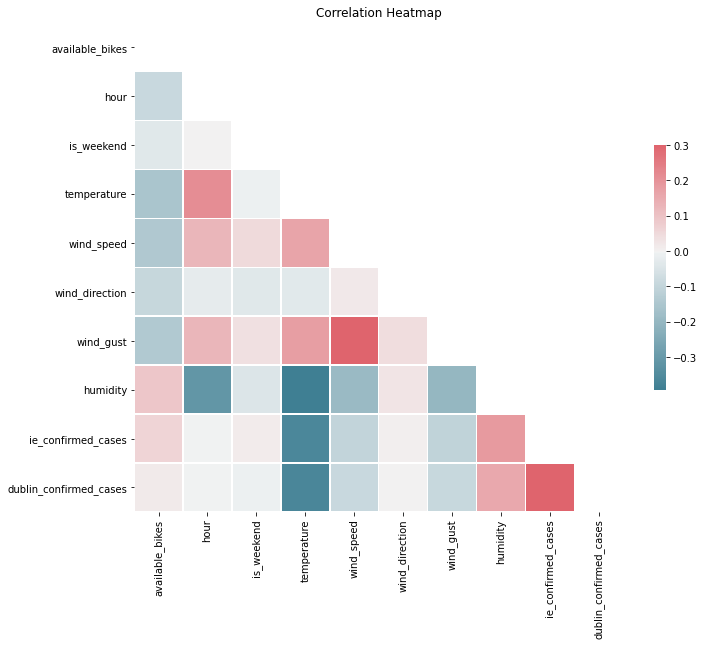

In [19]:
# Show correlation heatmap
corr = df[numeric_list].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = seaborn.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
seaborn.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Correlation Heatmap")
plt.show()

3.3. Identify and remove outliers

In [20]:
# Backup the data with outliers
df_with_outliers = df.copy()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


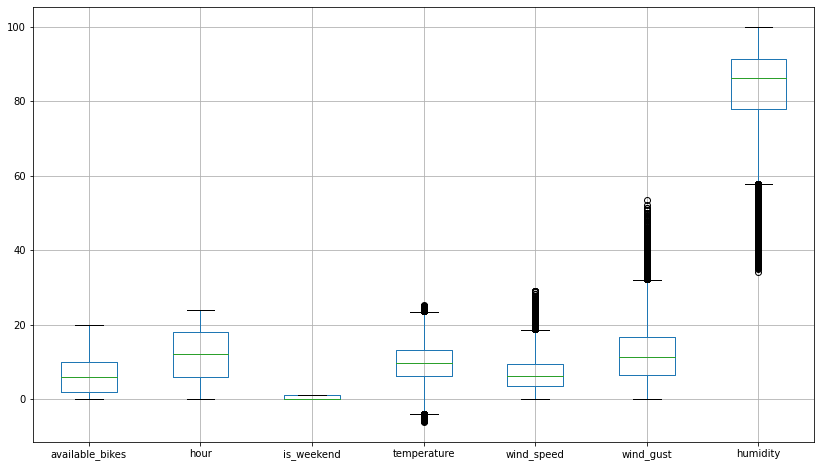

In [19]:
# Check the outliers
plt.figure(figsize=(14,8))
df.boxplot(column=['available_bikes',	'hour', 'is_weekend', \
                   'temperature',	'wind_speed',	\
                   'wind_gust', 'humidity'])

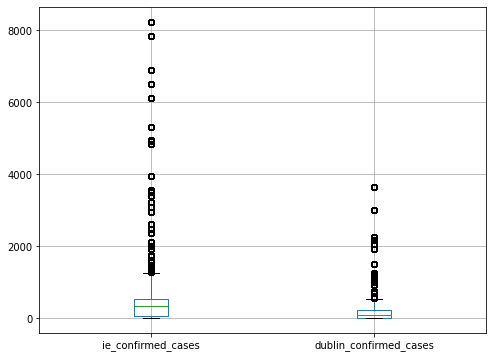

In [20]:
plt.figure(figsize=(8,6))
df.boxplot(column=['ie_confirmed_cases', 'dublin_confirmed_cases'])

In [21]:
def remove_outliers(_df):
  #Replacing the outlier data values with NULL
  for x in ['available_bikes', 'temperature', 'wind_speed', 'wind_gust', \
            'humidity', 'ie_confirmed_cases', 'dublin_confirmed_cases']:
    q75,q25 = np.percentile(_df.loc[:,x],[75,25])
    intr_qr = q75-q25
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
    _df.loc[_df[x] < min,x] = np.nan
    _df.loc[_df[x] > max,x] = np.nan

  # Remove outliers
  _df.dropna(axis = 0, inplace=True)

  return _df

In [22]:
# Run the function above
#print('Data length before removing outliers:', len(df))
#df = remove_outliers(df)
#print('Data length afer removing outliers:', len(df))

#4. Data Modelling

## 4.1. For a particular Bike Station

4.1.1 Data featuring

In [86]:
# List of features (predictors)
features = df.columns.to_list()
features.remove('date')
features.remove('available_bikes')
features

# Remove remaining NA rows 
df.dropna(inplace=True)

# Data for modelling is ready
y = df['available_bikes']
X = df[features]

4.1.2. Split data into training & testing

In [87]:
# Split into traning and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, \
                                    test_size=0.3, random_state=1, stratify=y)

4.1.3. Feature Scaling

In [88]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

4.1.4. Build a Random Rorest model

In [89]:
# Let's try with n_estimators=70 ==> using 70 Decision Trees
model = RandomForestClassifier(n_estimators=70)

model = model.fit(X_train, y_train)

y_prediction = model.predict(X_test)

# Show metrics & the prediction accuracy
print("MAE:", metrics.mean_absolute_error(y_test, y_prediction))
print("MSE:", metrics.mean_squared_error(y_test, y_prediction))
print("RMSE:", metrics.mean_squared_error(y_test, y_prediction)**0.5)
print("R2:", metrics.r2_score(y_test, y_prediction))
print("Accuracy:", metrics.accuracy_score(y_test, y_prediction))

MAE: 0.4202759939882498
MSE: 1.323131575351824
RMSE: 1.1502745652025101
R2: 0.9419459499722155
Accuracy: 0.7453203989616067


In [94]:
type(y_test)

pandas.core.series.Series

In [80]:
# Let's try with 200 Decision Trees
model = RandomForestClassifier(n_estimators=200)

model = model.fit(X_train, y_train)

y_prediction = model.predict(X_test)

print("MAE:", metrics.mean_absolute_error(y_test, y_prediction))
print("MSE:", metrics.mean_squared_error(y_test, y_prediction))
print("RMSE:", metrics.mean_squared_error(y_test, y_prediction)**0.5)
print("R2:", metrics.r2_score(y_test, y_prediction))
print("Accuracy:", metrics.accuracy_score(y_test, y_prediction))

MAE: 0.4092544518832263
MSE: 1.2654734253313293
RMSE: 1.124932631463471
R2: 0.9444757733005639
Accuracy: 0.7485312201120372


4.1.5. Examine the importance of predictors

In [83]:
percentages = list(model.feature_importances_)
# Merge variables and percentages
feature_percent = [(f, round(p*100, 2)) for f, p in zip(features, percentages)]
# Sort by the most contribution
feature_percent = sorted(feature_percent, key = lambda x: x[1], reverse = True)
# Show the data
print('Contribution percentage of variables:')
[print('{:40} {}%'.format(*pair)) for pair in feature_percent];

Contribution percentage of variables:
hour                                     15.68%
temperature                              13.68%
humidity                                 13.24%
wind_direction                           10.92%
wind_gust                                10.66%
wind_speed                               9.64%
ie_confirmed_cases                       9.55%
dublin_confirmed_cases                   8.45%
weekday_Thu                              0.88%
weekday_Wed                              0.86%
weekday_Fri                              0.85%
weekday_Mon                              0.84%
conditions_Clear                         0.82%
weekday_Tue                              0.71%
is_weekend                               0.65%
weekday_Sun                              0.61%
weekday_Sat                              0.58%
conditions_Rain                          0.5%
conditions_Overcast                      0.49%
conditions_Partially cloudy              0.21%
conditions_Rain, O

4.1.6. Check the diffrence between the actual and predicted values

In [84]:
test_vs_pred = pd.concat([y_test, pd.DataFrame(y_prediction, \
                                               columns=['predicted_bikes'], \
                                               index=y_test.index)], axis=1)
test_vs_pred['difference'] = test_vs_pred['available_bikes'] - test_vs_pred['predicted_bikes']
test_vs_pred.reset_index(drop=True, inplace=True)
test_vs_pred.describe()

,available_bikes,predicted_bikes,difference
count,43914.000000,43914.000000,43914.000000
mean,6.562964,6.522339,0.040625
std,4.774086,4.811527,1.124212
min,0.000000,0.000000,-19.000000
25%,3.000000,2.000000,0.000000
50%,6.000000,6.000000,0.000000
75%,10.000000,10.000000,0.000000
max,20.000000,20.000000,20.000000


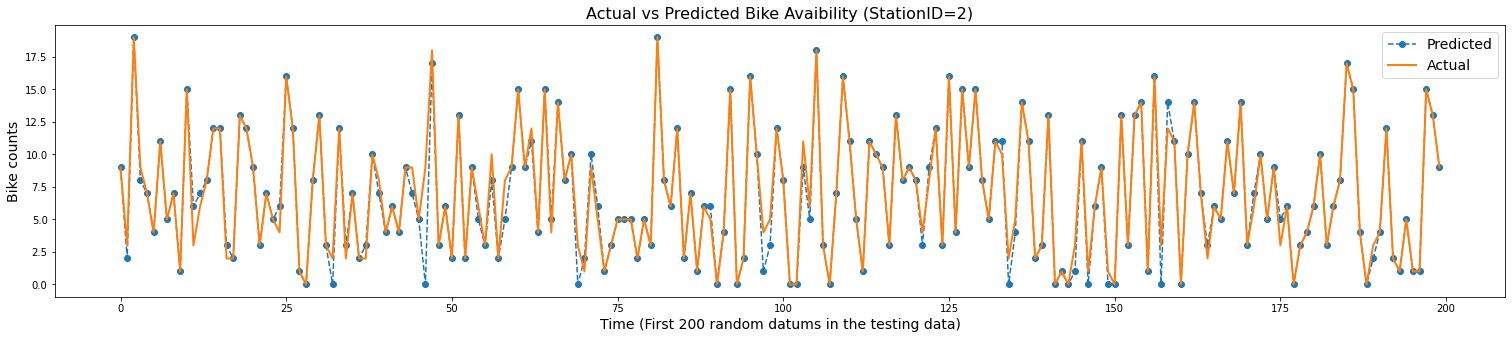

In [86]:
# Compare actual & predicted
# i.e. plot the first 200 rows
plt.figure(figsize=(26,5))
plt.plot(test_vs_pred['predicted_bikes'][:200], marker='o', \
         markersize=6, linestyle='dashed', label='Predicted')
plt.plot(test_vs_pred['available_bikes'][:200], linewidth=2, label='Actual')
plt.title('Actual vs Predicted Bike Avaibility (StationID='+str(stationId)+')', size=16)
plt.xlabel('Time (First 200 random datums in the testing data)', size=14)
plt.ylabel('Bike counts', size=14)
plt.legend(fontsize=14)
plt.show()

4.1.7.a. Observe actual & predicted data of a particular day

MAE: 0.059027777777777776
MSE: 0.09375
RMSE: 0.30618621784789724
R2: 0.9899102615339102
Accuracy: 0.9548611111111112


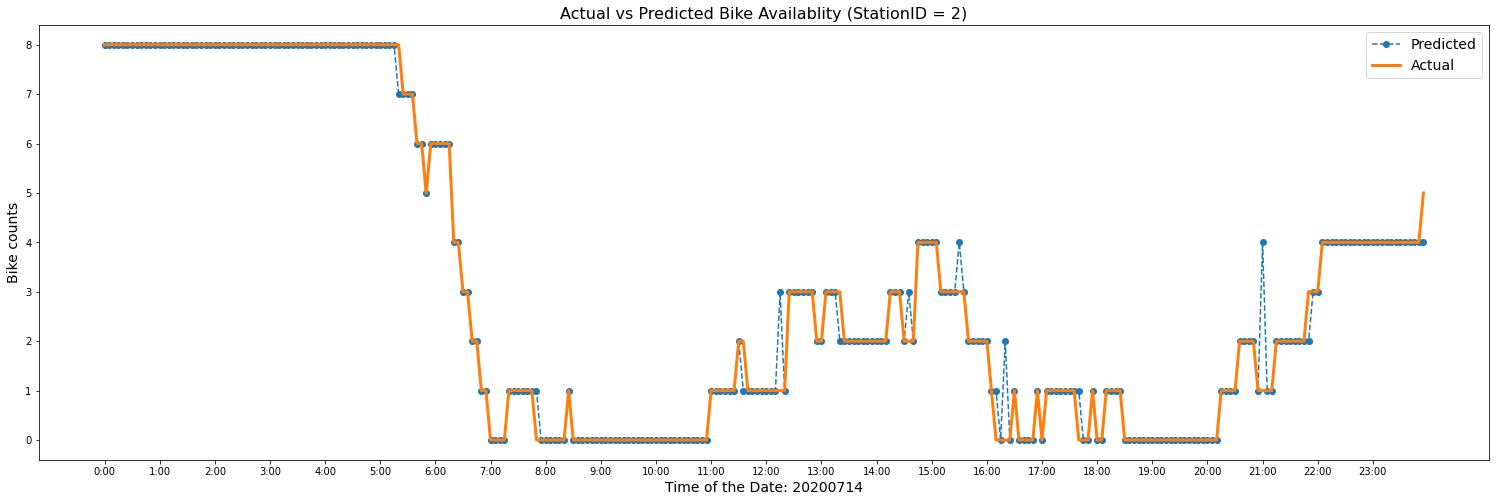

In [87]:
date1 = 20200714
df1 = df_with_outliers[(df_with_outliers['date'] == date1)]

df1.dropna(inplace=True)

if df1.empty:
  print('DataFrame is empty!')
else:
  y_test_1 = df1['available_bikes']
  X_test_1 = df1[features]

  X_test_1 = sc.transform(X_test_1)

  y_prediction_1 = model.predict(X_test_1)

  print("MAE:", metrics.mean_absolute_error(y_test_1, y_prediction_1))
  print("MSE:", metrics.mean_squared_error(y_test_1, y_prediction_1))
  print("RMSE:", metrics.mean_squared_error(y_test_1, y_prediction_1)**0.5)
  print("R2:", metrics.r2_score(y_test_1, y_prediction_1))
  print("Accuracy:", metrics.accuracy_score(y_test_1, y_prediction_1))

  y_test_1.reset_index(inplace=True, drop=True)

  y_prediction_1 = pd.Series(y_prediction_1)

  plt.figure(figsize=(26,8))
  plt.plot(y_prediction_1, marker='o', markersize=6, linestyle='dashed', label='Predicted')
  plt.plot(y_test_1, linewidth=3, label='Actual')
  plt.title('Actual vs Predicted Bike Availablity (StationID = ' + str(stationId) + ')', size=16)
  plt.xlabel('Time of the Date: ' + str(date1), size=14)
  plt.ylabel('Bike counts', size=14)

  x = [0]
  for i in range(0,23):
    x.append(x[i]+12)
  plt.xticks(x, ['0:00','1:00','2:00','3:00','4:00','5:00', \
                 '6:00','7:00','8:00','9:00','10:00','11:00', \
                 '12:00','13:00','14:00','15:00','16:00','17:00', \
                 '18:00','19:00','20:00','21:00','22:00','23:00'])

  plt.legend(fontsize=14)
  plt.show()

4.1.7.b. Observe actual & predicted data of a period of time (i.e, a month)

MAE: 0.11867463090273865
MSE: 0.26946917615237237
RMSE: 0.5191042054851535
R2: 0.9906672658547306
Accuracy: 0.9212216837597205


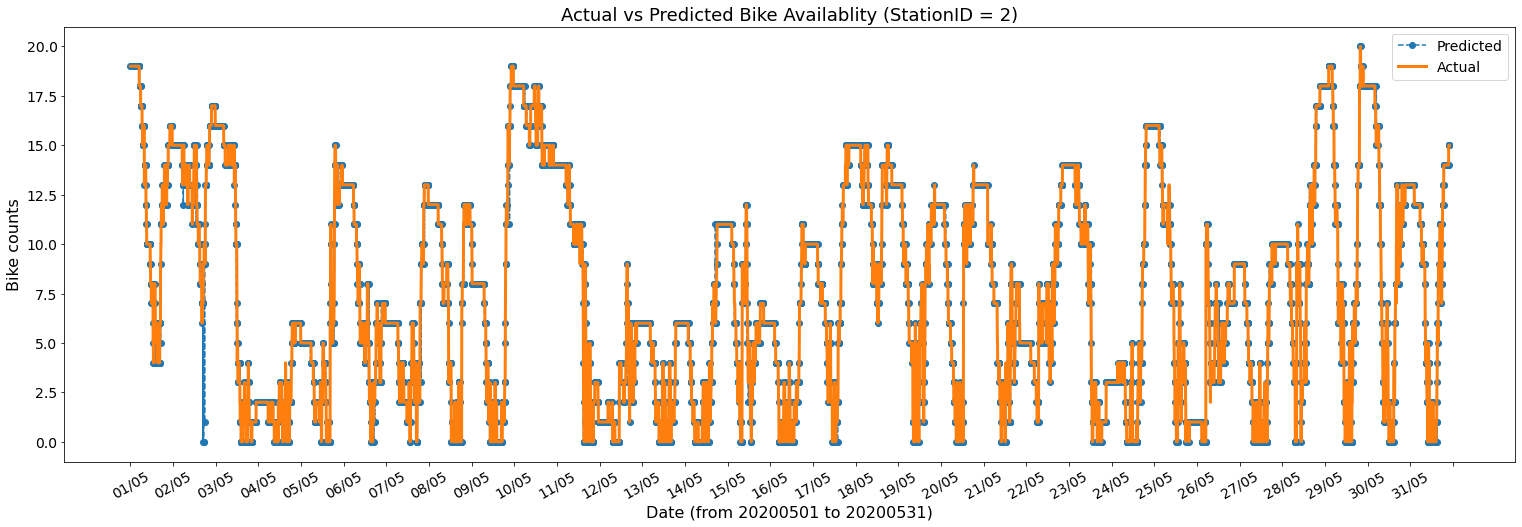

In [88]:
dfrom = 20200501
dto = 20200531

df1 = df_with_outliers[(df_with_outliers['date'] >= dfrom) & (df_with_outliers['date'] <= dto)]
df1.dropna(inplace=True)

if df1.empty:
  print('DataFrame is empty!')
else:
  y_test_1 = df1['available_bikes']
  X_test_1 = df1[features]

  X_test_1 = sc.transform(X_test_1)

  y_prediction_1 = model.predict(X_test_1)

  print("MAE:", metrics.mean_absolute_error(y_test_1, y_prediction_1))
  print("MSE:", metrics.mean_squared_error(y_test_1, y_prediction_1))
  print("RMSE:", metrics.mean_squared_error(y_test_1, y_prediction_1)**0.5)
  print("R2:", metrics.r2_score(y_test_1, y_prediction_1))
  print("Accuracy:", metrics.accuracy_score(y_test_1, y_prediction_1))

  y_test_1.reset_index(inplace=True, drop=True)

  y_prediction_1 = pd.Series(y_prediction_1)

  plt.figure(figsize=(26,8))
  plt.plot(y_prediction_1, marker='o', markersize=6, linestyle='dashed', label='Predicted')
  plt.plot(y_test_1, linewidth=3, label='Actual')
  plt.title('Actual vs Predicted Bike Availablity (StationID = ' + str(stationId) + ')', size=18)
  plt.xlabel('Date (from ' + str(dfrom) + ' to ' + str(dto) + ')', size=16)
  plt.ylabel('Bike counts', size=16)

  day_list = df1[['date']].drop_duplicates()['date'].apply(lambda x: str(x)[6:8] + '/' + str(x)[4:6])
  day_list = day_list.tolist()
  x = [0]
  for i in range(0,len(day_list)):
    x.append(x[i]+int(len(df1)/len(day_list))+1)
  plt.xticks(rotation=30)
  plt.xticks(x, day_list, fontsize=14)
  plt.yticks(fontsize=14)

  plt.legend(fontsize=14)
  plt.show()

4.1.8. Save model into a file

In [82]:
# bz2 for compression
import bz2
# pickle for writing/reading model to/from a file
import pickle

# I've already connected Google Colab with Google Drive.
# I'll save all models into my Google Drive
model_path = 'drive/MyDrive/dublinbikes/single_station_model/stationId_' + str(stationId) + '.pbz2'
with bz2.BZ2File(model_path, 'w') as f:
  pickle.dump(model, f)

4.1.9. Save metrics of each model for report

In [89]:
# rf: random_forest model
# mae: mean_absolute_error
# mse: mean_squared_error
# rmse: root of mean_squared_error
# r2: r2_score

# Initial columns for saving these metrics
stations_df['rf_mae'] = np.nan
stations_df['rf_mse'] = np.nan
stations_df['rf_rmse'] = np.nan
stations_df['rf_r2'] = np.nan
stations_df['rf_accuracy'] = np.nan

stations_df.head(5)

,address,station_id,latitude,longitude,name,rf_mae,rf_mse,rf_rmse,rf_r2,rf_accuracy
0,Clarendon Row,1,53.340927,-6.262501,CLARENDON ROW,NaN,NaN,NaN,NaN,NaN
1,Blessington Street,2,53.356770,-6.268140,BLESSINGTON STREET,NaN,NaN,NaN,NaN,NaN
2,Bolton Street,3,53.351181,-6.269859,BOLTON STREET,NaN,NaN,NaN,NaN,NaN
3,Greek Street,4,53.346874,-6.272976,GREEK STREET,NaN,NaN,NaN,NaN,NaN
4,Charlemont Street,5,53.330662,-6.260177,CHARLEMONT PLACE,NaN,NaN,NaN,NaN,NaN


In [91]:
# Assign the metrics to to the Station being processed

# Get the index of this Station in the dataframe 
i = stations_df[stations_df['station_id'] == stationId].index

stations_df.loc[i,'rf_mae'] = metrics.mean_absolute_error(y_test, y_prediction)
stations_df.loc[i,'rf_mse'] = metrics.mean_squared_error(y_test, y_prediction)
stations_df.loc[i,'rf_rmse'] = metrics.mean_squared_error(y_test, y_prediction)**0.5
stations_df.loc[i,'rf_r2'] = metrics.r2_score(y_test, y_prediction)
stations_df.loc[i,'rf_accuracy'] = metrics.accuracy_score(y_test, y_prediction)

# Show the data after assigning
stations_df[stations_df['station_id'] == stationId]

,address,station_id,latitude,longitude,name,rf_mae,rf_mse,rf_rmse,rf_r2,rf_accuracy
1,Blessington Street,2,53.35677,-6.26814,BLESSINGTON STREET,0.409254,1.265473,1.124933,0.944476,0.748531


## 4.2. For other Bike Stations

In [92]:
dfrom = 20200101
dto = 20210630

# The 1st Station (index=0, stationId=1) has been ignored as it has no data
# The 2nd Station (index=1, stationId=2) has been examined above.
# Now, we loop all the other Stations
# Let's begin with index=2
start = 2
# It takes lots of time to load/transform/extract data; 
# build model; compress & save the model into a file.
# To process all these steps for a Station, it will take about 3 minutes.
# Therefore, each time you should try 3 or 5 Stations and observe the results
# instead of loop all 116 Stations
end = 3
# end = len(stations_df)

for i in range(start,end):
  stationId = stations_df.loc[i,'station_id']
  print('index =',i,'. Getting data of the StationId =', stationId)
  while True:
    try:
      df = getDataOfAStation(main_df, dfrom, dto, stationId)
      break
    except:
      print('API time out. Retrying...')
  if df is None:
    print('No data of the stationID =',stationId, 'between', dfrom, 'and', dto)
  else:
    df = transform_data(df)
    df = merge_data(df, weather, covid_ireland, covid_dublin)
    df = dummy_data(df)
    #df = remove_outliers(df)
    # Remove remaining NA rows 
    df.dropna(inplace=True)

    # Data for modelling is ready
    # List of features (predictors)
    features = df.columns.to_list()
    features.remove('date')
    features.remove('available_bikes')
    features

    y = df['available_bikes']
    X = df[features]

    # Split into traning and testing data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)

    model = RandomForestClassifier(n_estimators=200)
    model = model.fit(X_train, y_train)

    y_prediction = model.predict(X_test)

    mae = metrics.mean_absolute_error(y_test, y_prediction)
    mse = metrics.mean_squared_error(y_test, y_prediction)
    rmse = metrics.mean_squared_error(y_test, y_prediction)**0.5
    r2 = metrics.r2_score(y_test, y_prediction)
    accuracy = metrics.accuracy_score(y_test, y_prediction)

    print("MAE:", mae)
    print("MSE:", mse)
    print("RMSE:", rmse)
    print("R2:", r2)
    print("Accuracy:", accuracy)

    # Save model for this station in a file (it is stored on Google Drive)
    #model_path = 'drive/MyDrive/dublinbikes/single_station_model/stationId_' + str(stationId) + '.pbz2'
    #with bz2.BZ2File(model_path, 'w') as f:
    #  pickle.dump(model, f)

    # Save metrics info of this single station model
    stations_df.loc[i,'rf_mae'] = mae
    stations_df.loc[i,'rf_mse'] = mse
    stations_df.loc[i,'rf_rmse'] = rmse
    stations_df.loc[i,'rf_r2'] = r2
    stations_df.loc[i,'rf_accuracy'] = accuracy

index = 2 . Getting data of the StationId = 3
MAE: 0.4353778751369113
MSE: 0.9879061701350857
RMSE: 0.9939346910814039
R2: 0.962792884628244
Accuracy: 0.7098621759766338


In [ ]:
# Save metrics info of these single station models into a file
# (It is stored in my Google Drive)
stations_df.to_csv('drive/MyDrive/dublinbikes/single_station_metrics.csv', index=False)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#5. Examine the metrics of single station models

In [93]:
s_metrics = pd.read_csv('drive/MyDrive/dublinbikes/single_station_metrics.csv')
s_metrics.dropna(inplace=True)

s_metrics.drop(columns=['address','latitude',	'longitude'], inplace=True)

In [94]:
s_metrics[['rf_mae','rf_mse','rf_rmse','rf_r2','rf_accuracy']].describe()

,rf_mae,rf_mse,rf_rmse,rf_r2,rf_accuracy
count,110.000000,110.000000,110.000000,110.000000,110.000000
mean,0.416398,1.512720,1.170235,0.968618,0.760456
std,0.199090,1.007373,0.380242,0.015912,0.091052
min,0.044749,0.309679,0.556488,0.887029,0.556072
25%,0.266166,0.749539,0.865759,0.963064,0.698458
50%,0.415274,1.271497,1.127607,0.971816,0.756542
75%,0.537719,1.992724,1.411636,0.979605,0.833280
max,1.023739,5.804601,2.409274,0.988556,0.980489


In [95]:
models_count = len(s_metrics)

In [96]:
print('Number of models with accuracy > 0.75 are', \
      len(s_metrics[s_metrics['rf_accuracy'] > 0.75]), '/', models_count, ' models')
print('Number of models with accuracy > 0.80 are', \
      len(s_metrics[s_metrics['rf_accuracy'] > 0.80]), '/', models_count, ' models')
print('Number of models with accuracy > 0.85 are', \
      len(s_metrics[s_metrics['rf_accuracy'] > 0.85]), '/', models_count, ' models')

Number of models with accuracy > 0.75 are 57 / 110  models
Number of models with accuracy > 0.80 are 37 / 110  models
Number of models with accuracy > 0.85 are 20 / 110  models


In [97]:
# Top 5 models (highest accuracy)
s_metrics.sort_values(by=['rf_accuracy'], ascending=False)[:5]

,station_id,name,rf_mae,rf_mse,rf_rmse,rf_r2,rf_accuracy
92,94,HEUSTON STATION (CAR PARK),0.044749,0.321647,0.567139,0.986591,0.980489
91,93,HEUSTON STATION (CENTRAL),0.084964,0.589250,0.767626,0.982562,0.966036
102,104,GRANGEGORMAN LOWER (CENTRAL),0.117122,0.428073,0.654273,0.984525,0.929682
53,55,HATCH STREET,0.123747,0.384953,0.620446,0.981691,0.915366
115,117,HANOVER QUAY EAST,0.127879,0.309679,0.556488,0.984808,0.909539


In [98]:
# Bottom 5 models (lowest accuracy)
s_metrics.sort_values(by=['rf_accuracy'], ascending=True)[:5]

,station_id,name,rf_mae,rf_mse,rf_rmse,rf_r2,rf_accuracy
67,69,GRAND CANAL DOCK,0.964714,4.622805,2.150071,0.958896,0.556072
31,33,PRINCES STREET / O'CONNELL STREET,1.023739,5.804601,2.409274,0.887029,0.580538
32,34,PORTOBELLO HARBOUR,0.884300,4.023928,2.005973,0.943747,0.586231
8,9,EXCHEQUER STREET,0.951545,4.909698,2.215784,0.908771,0.592679
29,31,PARNELL STREET,0.712884,2.137337,1.461964,0.935907,0.602814


# 6. Time-series Models

##6.1. Define a function to get dataset by for time-series model

In [14]:
def getDataForTimeSeriesModel(_df, _dfrom, _dto, _stationId):
  temp_df = getDataOfAStation(_df, _dfrom, _dto, _stationId)
  if temp_df.empty:
    print('No data of the stationID =',_stationId, 'between', _dfrom, 'and', _dto)
  temp_df = temp_df[(temp_df['minute'] == 0) | (temp_df['minute'] == 15) | \
                        (temp_df['minute'] == 30) | (temp_df['minute'] == 45)]

  temp_df = temp_df[['time_interval', 'available_bikes']]
  temp_df.reset_index(drop=True, inplace=True)
  temp_df['time_interval'] = temp_df['time_interval'].apply(lambda x: \
                                      pd.datetime.strptime(str(x),'%Y%m%d%H%M'))
  temp_df.to_csv('interval_windows.csv', index=False)
  series = pd.read_csv('interval_windows.csv', \
                       header=0, index_col=0, parse_dates=True, squeeze=True)
  return series

##6.2. Define a function to build a time-series model

In [39]:
def time_series_model(_series):
  # Fit model
  model = ARIMA(_series, order=(1,1,1))
  model_fit = model.fit()
  # Summary of fit model
  print(model_fit.summary())
  # Line plot of residuals
  residuals = pd.DataFrame(model_fit.resid)
  residuals.plot()
  plt.show()
  # Density plot of residuals
  residuals.plot(kind='kde')
  plt.show()
  # Summary stats of residuals
  print(residuals.describe())


  # Evaluate an ARIMA model using a walk-forward validation
  # Split into training and testing sets
  X = series.values
  size = int(len(X) * 0.8) # 80% for training
  train, test = X[0:size], X[size:len(X)]
  history = [x for x in train]

  predictions15 = list()
  test30 = list()
  test45 = list()
  test60 = list()
  test90 = list()
  test120 = list()
  predictions30 = list()
  predictions45 = list()
  predictions60 = list()
  predictions90 = list()
  predictions120 = list()
  # Walk-forward validation
  for t in range(len(test)):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    output = model_fit.predict(len(history), len(history)+7, typ='levels')
    predictions15.append(output[0])
 
    if (t+1 < len(test)):
      test30.append(test[t+1])
      predictions30.append(output[1])
    if (t+2 < len(test)):
      test45.append(test[t+2])
      predictions45.append(output[2])
    if (t+3 < len(test)):
      test60.append(test[t+3])
      predictions60.append(output[3])
    if (t+5 < len(test)):
      test90.append(test[t+5])
      predictions90.append(output[5])
    if (t+7 < len(test)):
      test120.append(test[t+7])
      predictions120.append(output[7])

    obs = test[t]
    history.append(obs)

  # Save metrics
  metrics_output = list()
  # prediction window: 15-minutes
  metrics_output.append(metrics.mean_absolute_error(test, predictions15))
  metrics_output.append(metrics.mean_squared_error(test, predictions15))
  metrics_output.append(metrics.mean_squared_error(test, predictions15)**0.5)
  metrics_output.append(metrics.r2_score(test, predictions15))
  # prediction window: 30-minutes
  metrics_output.append(metrics.mean_absolute_error(test30, predictions30))
  metrics_output.append(metrics.mean_squared_error(test30, predictions30))
  metrics_output.append(metrics.mean_squared_error(test30, predictions30)**0.5)
  metrics_output.append(metrics.r2_score(test30, predictions30))
  # prediction window: 45-minutes
  metrics_output.append(metrics.mean_absolute_error(test45, predictions45))
  metrics_output.append(metrics.mean_squared_error(test45, predictions45))
  metrics_output.append(metrics.mean_squared_error(test45, predictions45)**0.5)
  metrics_output.append(metrics.r2_score(test45, predictions45))
  # prediction window: 60-minutes
  metrics_output.append(metrics.mean_absolute_error(test60, predictions60))
  metrics_output.append(metrics.mean_squared_error(test60, predictions60))
  metrics_output.append(metrics.mean_squared_error(test60, predictions60)**0.5)
  metrics_output.append(metrics.r2_score(test60, predictions60))
  # prediction window: 90-minutes
  metrics_output.append(metrics.mean_absolute_error(test90, predictions90))
  metrics_output.append(metrics.mean_squared_error(test90, predictions90))
  metrics_output.append(metrics.mean_squared_error(test90, predictions90)**0.5)
  metrics_output.append(metrics.r2_score(test90, predictions90))
  # prediction window: 120-minutes
  metrics_output.append(metrics.mean_absolute_error(test120, predictions120))
  metrics_output.append(metrics.mean_squared_error(test120, predictions120))
  metrics_output.append(metrics.mean_squared_error(test120, predictions120)**0.5)
  metrics_output.append(metrics.r2_score(test120, predictions120))

  # Plot forecasts against actual outcomes
  plt.figure(figsize=(26,8))
  plt.plot(predictions15[:100], marker='o', markersize=6, linestyle='dashed', label='Predicted')
  plt.plot(test[:100], linewidth=3, label='Actual')
  plt.title('Actual vs Predicted Bike Availablity with Prediction Window 15-minutes (StationID = ' + str(stationId) + ')', size=18)
  plt.xlabel('Time (First 100 datums in the testing data)', size=16)
  plt.ylabel('Bike counts', size=16)
  plt.legend(fontsize=14)
  plt.show()

  plt.figure(figsize=(26,8))
  plt.plot(predictions30[:100], marker='o', markersize=6, linestyle='dashed', label='Predicted')
  plt.plot(test30[:100], linewidth=3, label='Actual')
  plt.title('Actual vs Predicted Bike Availablity with Prediction Window 30-minutes (StationID = ' + str(stationId) + ')', size=18)
  plt.xlabel('Time (First 100 datums in the testing data)', size=16)
  plt.ylabel('Bike counts', size=16)
  plt.legend(fontsize=14)
  plt.show()

  plt.figure(figsize=(26,8))
  plt.plot(predictions120[:100], marker='o', markersize=6, linestyle='dashed', label='Predicted')
  plt.plot(test120[:100], linewidth=3, label='Actual')
  plt.title('Actual vs Predicted Bike Availablity with Prediction Window 120-minutes (StationID = ' + str(stationId) + ')', size=18)
  plt.xlabel('Time (First 100 datums in the testing data)', size=16)
  plt.ylabel('Bike counts', size=16)
  plt.legend(fontsize=14)
  plt.show()
  return metrics_output


#6.3. Time-series model for StationID = 2

                               SARIMAX Results                                
Dep. Variable:        available_bikes   No. Observations:                 2875
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -5378.441
Date:                Fri, 27 Aug 2021   AIC                          10762.883
Time:                        22:07:27   BIC                          10780.773
Sample:                             0   HQIC                         10769.332
                               - 2875                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8121      0.125     -6.510      0.000      -1.057      -0.568
ma.L1          0.8389      0.117      7.162      0.000       0.609       1.069
sigma2         2.4718      0.015    167.414      0.0

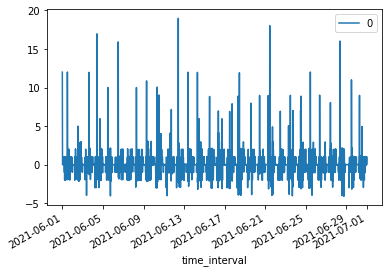

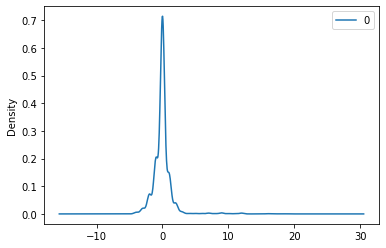

                 0
count  2875.000000
mean      0.001781
std       1.588050
min      -4.113605
25%      -0.186360
50%      -0.001896
75%       0.038674
max      18.984021


In [ ]:
import warnings
warnings.filterwarnings("ignore")

dfrom = 20210601
dto = 20210630
#stationId = 69
stationId = 2

series = getDataForTimeSeriesModel(main_df, dfrom, dto, stationId)
if series.empty:
  print('No data found!')
else:
  metrics_output = time_series_model(series)

In [42]:
metrics_output

[0.03968560321548216,
 0.10971310037890282,
 0.33122967919391344,
 0.9826152395250809,
 0.07846214664861356,
 0.2232780682806455,
 0.4725230875636084,
 0.9641354103685468,
 0.11661499030279933,
 0.3370735144739508,
 0.5805803256001282,
 0.9450989816920303,
 0.15104189476767452,
 0.44775513661178656,
 0.6691450788967864,
 0.9260286968443475,
 0.21917469668533646,
 0.6697747122583335,
 0.8183976492258109,
 0.8860543845812072,
 0.28024397957887215,
 0.882976600921574,
 0.9396683462379554,
 0.845100769850885]

In [12]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	rmse = metrics.mean_squared_error(test, predictions)**0.5
	return rmse

def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s MSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [13]:
import warnings
# evaluate parameters
p_values = [0, 1, 2, 4]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=7.455


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 0, 1) MSE=4.505


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 0, 2) MSE=3.044
ARIMA(0, 1, 0) MSE=1.940
ARIMA(0, 1, 1) MSE=1.926
ARIMA(0, 1, 2) MSE=1.924
ARIMA(0, 2, 0) MSE=2.476
ARIMA(0, 2, 1) MSE=1.959
ARIMA(0, 2, 2) MSE=1.939
ARIMA(1, 0, 0) MSE=1.926
ARIMA(1, 0, 1) MSE=1.906
ARIMA(1, 0, 2) MSE=1.906
ARIMA(1, 1, 0) MSE=1.929


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA(1, 1, 1) MSE=1.938
ARIMA(1, 1, 2) MSE=1.924
ARIMA(1, 2, 0) MSE=2.365


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(1, 2, 1) MSE=1.941
ARIMA(1, 2, 2) MSE=1.937
ARIMA(2, 0, 0) MSE=1.908


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals

ARIMA(2, 0, 1) MSE=1.907


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/

ARIMA(2, 0, 2) MSE=1.901
ARIMA(2, 1, 0) MSE=1.922


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals

ARIMA(2, 1, 1) MSE=1.919


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: 

ARIMA(2, 1, 2) MSE=1.968
ARIMA(2, 2, 0) MSE=2.290
ARIMA(2, 2, 1) MSE=1.939


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: 

ARIMA(2, 2, 2) MSE=1.959
ARIMA(4, 0, 0) MSE=1.916


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: 

ARIMA(4, 0, 1) MSE=1.919


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: 

ARIMA(4, 0, 2) MSE=1.937
ARIMA(4, 1, 0) MSE=1.942
ARIMA(4, 1, 1) MSE=1.953


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/

ARIMA(4, 1, 2) MSE=1.975
ARIMA(4, 2, 0) MSE=2.190
ARIMA(4, 2, 1) MSE=2.338


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: 

ARIMA(4, 2, 2) MSE=1.951
Best ARIMA(2, 0, 2) MSE=1.901


##6.4. Time-series models for the remaining Bike Stations